#Начальные установки и загрузка

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import sys
from IPython.display import clear_output
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Грузим основной датасет
data_path = '/content/drive/MyDrive/internship/karate/dataset'
filename = 'dataset__all_features_phase.csv'
df = pd.read_csv(os.path.join(data_path,filename)) #Основной датасет

In [ ]:
#Проверим существование столбца для сохранения фаз, если отсутствует, то добавим
if 'phase' not in df.columns:
  df['phase']=np.zeros_like(len(df))
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,1,...,0.925819,0.330658,-0.183095,0.842526,-0.251213,0.476489,0.787591,0.045598,0.614508,0
1,0,0,0,0,0,0,0,0,0,1,...,0.908620,0.318595,-0.270015,0.847875,-0.252573,0.466171,0.856474,0.052875,0.513474,0
2,0,0,0,0,0,0,0,0,0,1,...,0.820056,0.288839,-0.494045,0.831219,-0.246556,0.498283,0.849801,0.051036,0.524627,0
3,0,0,0,0,0,0,0,0,0,1,...,0.842421,0.290291,-0.453936,0.830638,-0.245556,0.499743,0.846481,0.050976,0.529973,0
4,0,0,0,0,0,0,0,0,0,1,...,0.822300,0.278694,-0.496137,0.847154,-0.250359,0.468669,0.868949,0.052760,0.492081,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,1,0,0,0,0,0,0,0,...,0.698299,0.489481,-0.522291,0.552038,-0.363697,0.750319,0.636238,-0.042069,0.770345,1
142364,0,0,1,0,0,0,0,0,0,0,...,0.704808,0.496040,-0.507139,0.534342,-0.367378,0.761257,0.638538,-0.042032,0.768442,1
142365,0,0,1,0,0,0,0,0,0,0,...,0.770869,0.539021,-0.339435,0.557973,-0.401605,0.726209,0.648042,-0.042260,0.760431,1
142366,0,0,1,0,0,0,0,0,0,0,...,0.771385,0.555455,-0.310540,0.563317,-0.430092,0.705475,0.653394,-0.044460,0.755711,1


#Основные функции

##Для разметки

In [ ]:
phase_dic={
    'uncnown':0,
    'stance':1,
    'kick':2,
    'return':3,
    'swing':4
}

In [ ]:
def str2int(value):
  '''
  Преобразует строку в целое число, в случае неудачи возвращает None
  '''
  value=value.strip()
  try:
    v=int(value)
    return v
  except ValueError:
    return None

In [ ]:
def get_diapazon(value):
  '''
  Принимает на вход строку, содержащую число или диапазон 2 чисел раздеделенных -
  Возврашает 2 числа, нижний и верхний пределы диапазона
  '''
  values=value.split('-')
  if len(values)==1:
    v=str2int(value)
    return v,v
  if len(values)==2:
    v1=str2int(values[0])
    v2=str2int(values[1])
    return v1,v2
  return None,None


In [ ]:
def process_data(file_name,data,mark):
  '''
  Обрабатывает одну колонку (все данные об одной фазе) удара
  file_name - имя обрабатываемого видеофайла
  data - строка, содержащая диапазоны кадров для данной фазы, данного видео файла
  mark - метка фазы
  '''
  if data is np.NaN:
    return
  data=data.strip()
  diapasons=data.split(';')
  for diapazon in diapasons:
    diapazon=diapazon.strip()
    if diapazon=='':
      continue
    v_min,v_max=get_diapazon(diapazon)
    if v_min is None or v_max is None:
      print(f'Файл: {file_name}. Ошибка преобразования диапазона: {diapazon}. Метка: {mark}')
      continue
    df.loc[(df['filename']==file_name) & (df['frame#'].isin(range(v_min,v_max+1))),'phase']=mark

In [ ]:
def process_row(row):
  '''
  Обрабатывает одну строку (один видео файл) из файла с маркерами
  row  - строка из датасета с маркерами
  '''
  file_name=row.loc['file'] #Первый столбец это название обрабатываемого ведео файла
  l=len(df[df['filename']==file_name])
  if l==0:
    #Если имя файла в xlsx  написано не верно, то для него не будет найдено данных. Сообщим об этом
    print(f'ВНИМАНИЕ!!! ДЛЯ ФАЙЛА {file_name} НЕ ОБНАРУЖЕНО ДАННЫХ В ДАТАСЕТЕ!!! ПРОВЕРЬ ПРАВИЛЬНОСТЬ НАПИСАНИЯ ИМЕНИ ФАЙЛА!!!')
  else:
    print (f'Обработка {file_name}. Всего {l} кадров')
  for column in row.index[1:]:
    mark=phase_dic[column] #Метка фазы
    data=row[column]

    print (f'Файл: {file_name}  дата: {data} Метка {mark}')
    process_data(file_name,data,mark)


In [ ]:
def process_file(path):
  '''
  Выполняет обработку одного XLSX файла с маркерами
  '''
  print(f'Обработка файла {path}')
  df_marks=pd.read_excel(path)
  for row_index in df_marks.index:
    process_row(df_marks.loc[row_index])


#Разметка

In [ ]:
markup_path=os.path.join(data_path,'markups/main_dataset');
#Получаем список XLSX файлов с разметками
file_names=os.listdir(markup_path)
for file_name in file_names:
  _, ext=os.path.splitext(file_name)
  if ext!='.xlsx':
    continue
  path=os.path.join(markup_path,file_name)
  process_file(path)

Обработка файла /content/drive/MyDrive/internship/karate/dataset/markups/main_dataset/КИДЗАМИ ДЗУКИ.xlsx
Обработка Андрей КИДЗАМИ ДЗУКИ. Всего 440 кадров
Файл: Андрей КИДЗАМИ ДЗУКИ  дата: nan Метка 1
Файл: Андрей КИДЗАМИ ДЗУКИ  дата: 361-375; Метка 2
Файл: Андрей КИДЗАМИ ДЗУКИ  дата: 214-218; 256-258;298-302;340-343;383-387;426-429;293-301;334-347; Метка 3
Обработка Андрей КИДЗАМИ ДЗУКИ (2). Всего 478 кадров
Файл: Андрей КИДЗАМИ ДЗУКИ (2)  дата: 0-50;76-88;118-127;158-168;197-211;241-255;283-298;329-342;373-387;416-430;464-477; Метка 1
Файл: Андрей КИДЗАМИ ДЗУКИ (2)  дата: 51-63;89-101;128-142;169-182;212-225;256-270;299-313;343-357;388-402;431-446; Метка 2
Файл: Андрей КИДЗАМИ ДЗУКИ (2)  дата: 64-75;102-117;143-157;183-196;226-240;271-282;314-328;358-372;403-415;447-463; Метка 3
Обработка Андрей КИДЗАМИ ДЗУКИ (кулак 2). Всего 442 кадров
Файл: Андрей КИДЗАМИ ДЗУКИ (кулак 2)  дата: nan Метка 1
Файл: Андрей КИДЗАМИ ДЗУКИ (кулак 2)  дата: nan Метка 2
Файл: Андрей КИДЗАМИ ДЗУКИ

In [ ]:
df.to_csv(os.path.join(data_path,filename), index=False)

#Проверка результатов на видео

In [ ]:
#Возможные состояния
STATUS_STANCE=1
STATUS_KICK=2
STATUS_RET=3
STATUS_SWING=4

statuses={
    STATUS_STANCE:'STANCE',
    STATUS_KICK:'KICK',
    STATUS_RET:'RETURN',
    STATUS_SWING:'SWING'
}
DisplaySkipFrame=10

In [ ]:
#Посмотри, какие файлы у нас есть, например, для удара ГЕДАН БАРАЙ
kick_name='ГЕДАН'
file_names=[y for y in list(df['filename'].unique()) if y.find(kick_name)>=0]
file_names

['Андрей ГЕДАН БАРАЙ',
 'Дима ГЕДАН БАРАЙ',
 'Максим ГЕДАН БАРАЙ ',
 'Миша ГЕДАН БАРАЙ',
 'Оля ГЕДАН БАРАЙ',
 'Эрика ГЕДАН БАРАЙ',
 'Андрей ГЕДАН БАРАЙ (2)',
 'Дима ГЕДАН БАРАЙ (2)',
 'Максим ГЕДАН БАРАЙ',
 'Миша ГЕДАН БАРАЙ (2)',
 'Оля ГЕДАН БАРАЙ (2)',
 'Эрика ГЕДАН БАРАЙ (2)',
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)',
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 2)',
 'Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  2)',
 'Максим ГЕДАН БАРАЙ (замах прямой рукой  2)',
 'Максим ГЕДАН БАРАЙ (кулак развернут не верно 2)',
 'Максим ГЕДАН БАРАЙ (поворот корпуса за блоком  2)',
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)',
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)',
 'Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  1)',
 'Максим ГЕДАН БАРАЙ (замах прямой рукой  1)',
 'Максим ГЕДАН БАРАЙ (кулак развернут не верно 1)',
 'Максим ГЕДАН БАРАЙ (поворот корпуса за блоком  1)']

##Генерация видео

In [ ]:
def mark_move(df_marked,VideoPathIn, VideoPathOut):
  '''
  маркирует каждый кадр из видео VideoPathIn, в соответствии с данными df_marked.  Формирует новое видео  по VideoPathOut
  df_marked - размеченный датафрейм для этого видео
  reference_angles  - список референсных углов
  VideoPathIn - путь к исходному видеофайлу
  VideoPathIn - путь к итоговому видеофайлу
  dots - список точек, которые необходимо отображать на видео (как правило, соответствует точкам референсного угла)
  df - полный датасет, нужен. нужен, если предпологается выводить точки угла
  '''
  cap = cv2.VideoCapture(VideoPathIn)
  if (cap.isOpened() == False):
    print("Ошибка открытия видеофайла")
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_size=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  #print (frame_size)
  Output = cv2.VideoWriter(VideoPathOut, cv2.VideoWriter_fourcc(*'MP4V'), fps, frame_size)
  FrameIndex=0
  while(True): # Вывод кадров производится  в цикле
    ret, frame = cap.read()
    if total_frame_count<=FrameIndex:
      break;
    if not ret: #кадр не вернулся по какой то причине
      FrameIndex +=1
      continue
    status=df_marked.phase.iloc[FrameIndex]
    cv2.putText(frame, statuses[status], (10,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), 7)
    cv2.putText(frame, f'frame:{FrameIndex}', (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 7)

      #вывод кадров на экран (для отладки, потом убрать)
    if FrameIndex%DisplaySkipFrame==1: #Начиная с первого кадра каждой секунды
      clear_output(wait=True)
      min_frame =cv2.resize(frame, (int(frame.shape[1]/5),int(frame.shape[0]/5)))
      cv2_imshow(min_frame)
      print (f'Обработано {FrameIndex} кадров')

    Output.write(frame)
    FrameIndex+=1
  Output.release()
  cap.release()
  cv2.destroyAllWindows()
  print (f'Всего обработано {FrameIndex} кадров')

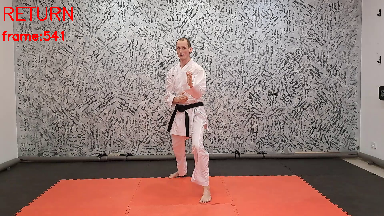

Обработано 541 кадров
Всего обработано 549 кадров


In [ ]:

file_name='Андрей ГЕДАН БАРАЙ'
df1=df[df['filename']==file_name].sort_values(['frame#'],ascending=True)
correct=df1.correct.iloc[0]
main_folder=df1.main_folder.iloc[0]
folder=df1.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'


mark_move(df1,VideoPathIn, VideoPathOut)